### Acceso a la base de datos Covid-19 en Colombia por medio de la API
Acceder a la totalidad de los datos puede gastar muchos recursos en la RAM, por lo que un PC con especificaciones bajas podría lanzar un "Memoryerror" en la consola de Python. Afortunadamente, la API de Socrata en Python (sodapy) permite hacer consultas en lenguaje SQL de Socrata, para así pedir solo la información necesaria a trabajar.

El presente notebook muestra el código necesario para generar una visualización de datos tomando dos grupos etarios grandes y al final combinar los datos y mostrar una unica visualización con un promedio de edad de muertes Covid-19 en Colombia.

In [1]:
# Importamos librerías necesarias para la lectura de los datos

import pandas as pd
from sodapy import Socrata
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


Acceder a los datos de la API requiere autenticación (Client), sino las consultas tienen un límite de filas. Para ello, es necesario registrarse en datos.gov.co y generar un Token App.

In [2]:
# Ponemos los datos requeridos para el acceso

client = Socrata("www.datos.gov.co",
                 "*********************", # No se debe compartir esta información
                 username="j*************",
                 password="************.") 

Para que el código quede más legible, vamos a separar la consulta (query) en un str aparte del .get 

In [3]:
# Generamos consulta (basada en lenguaje SQL)
# La consulta tiene la siguiente base: SELECT (lo que quiero escoger), WHERE (condicionales),
# AND|OR Y LIMIT (la población que queremos tener, en este caso ponemos un poco por encima del total de contagios >6 millones)

# primera consulta: datos con edad desde los 60 años
query = f"""SELECT fecha_reporte_web, departamento_nom, \
    ciudad_municipio_nom, edad, sexo, ubicacion, estado, recuperado, \
    fecha_inicio_sintomas, fecha_muerte WHERE edad > 59 AND \
        recuperado = 'Fallecido' OR recuperado = 'fallecido' AND edad > 59 LIMIT 6015000"""

# segunda consulta: datos con edades menores a 60 años
query2 = f"""SELECT fecha_reporte_web, departamento_nom, \
    ciudad_municipio_nom, edad, sexo, ubicacion, estado, recuperado, \
    fecha_inicio_sintomas, fecha_muerte  WHERE edad < 60 AND \
        recuperado =  'Fallecido' OR  recuperado = 'fallecido' AND edad < 60 LIMIT 6015000"""

Para evitarnos posibles errores, en la consulta ingresamos el condicional WHERE tanto para "Fallecido" como para "fallecido", eso para que los casos registrados con la "f" minuscula no queden por fuera de la consulta, así que acá los incluímos de una vez. (Esto lo hice porque ya conozco la base de datos, pero NO es recomendable porque es posible errores de otro tipo como "fallecid0, fallecidx, etc").
# Dataframe para mayores de 59 años

In [4]:
# Llamamos los datos de la primera consulta

results = client.get("gt2j-8ykr", query=query)

In [5]:
# Pasamos los resultados a dataframe y observamos el tipo de datos de origen

mayores_59 = pd.DataFrame.from_records(results)
mayores_59.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100399 entries, 0 to 100398
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   fecha_reporte_web      100399 non-null  object
 1   departamento_nom       100399 non-null  object
 2   ciudad_municipio_nom   100399 non-null  object
 3   edad                   100399 non-null  object
 4   sexo                   100399 non-null  object
 5   ubicacion              100399 non-null  object
 6   estado                 100399 non-null  object
 7   recuperado             100399 non-null  object
 8   fecha_inicio_sintomas  100399 non-null  object
 9   fecha_muerte           100399 non-null  object
dtypes: object(10)
memory usage: 7.7+ MB


Vemos que todas las columnas están en tipo object, y no hay valores nulos, así que pasamos las fechas a fechas con pandas y edad a un número entero.

In [18]:
# ajustamos tipo de datos según columnas
# Para las columnas en las que vamos a hacer hincapié, miramos si hay valores extraños que nos puedan corromper el análisis.

mayores_59[["fecha_reporte_web","fecha_inicio_sintomas","fecha_muerte"]] = \
    mayores_59[["fecha_reporte_web","fecha_inicio_sintomas","fecha_muerte"]].apply(pd.to_datetime)
mayores_59["edad"] = mayores_59["edad"].astype("int64")

# Es posible que haya nombres escritos de manera incorrecta, así que verificamos
print(mayores_59.departamento_nom.unique())
print(mayores_59.sexo.unique())
print(mayores_59.ubicacion.unique())
print(mayores_59.estado.unique())
print(mayores_59.recuperado.unique())

['ANTIOQUIA' 'CAQUETA' 'VALLE' 'MAGDALENA' 'ATLANTICO' 'NORTE SANTANDER'
 'HUILA' 'TOLIMA' 'META' 'CALDAS' 'BOYACA' 'RISARALDA' 'BOGOTA' 'CORDOBA'
 'QUINDIO' 'BOLIVAR' 'CASANARE' 'CUNDINAMARCA' 'NARIÑO' 'SUCRE' 'CAUCA'
 'SANTANDER' 'CESAR' 'CHOCO' 'GUAJIRA' 'AMAZONAS' 'ARAUCA' 'PUTUMAYO'
 'SAN ANDRES' 'VICHADA' 'VAUPES' 'GUAVIARE' 'GUAINIA']
['F' 'M']
['Fallecido']
['Fallecido']
['Fallecido']


En el tema de los departamentos, si quisieramos hacer un análisis con base a éstos, es mejor tomar solo los 32 + Bogotá y mover los distritos a sus departamentos correspondientes, ej: Santa Marta = Magdalena, Barranquilla = Atlántico. 
Otra cosa, como era de esperarse, hay un dato que se llama "Caldas" y como Python es case sensitive, es mejor convertirlo a "CALDAS", lo mismo para el resto de datos case sensitive.


In [8]:
# Convertimos "fallecido" a "Fallecido"
mayores_59["recuperado"].replace({"fallecido":"Fallecido"}, inplace=True)

# Arreglamos columna departamento_nom
mayores_59["departamento_nom"].replace\
({"BARRANQUILLA":"ATLANTICO","CARTAGENA":"BOLIVAR",\
  "STA MARTA D.E.":"MAGDALENA","Caldas":"CALDAS","Tolima":"TOLIMA"}, inplace=True)

# Arreglamos case sensitive en seso 
mayores_59["sexo"].replace({"f":"F","m":"M"}, inplace=True)

Agregamos columna en la que solo nos separe año-mes de fecha de muerte para futuros análisis.

In [9]:
# creamos columna año_mes para ignorar el día del mes en el que ocurrió el deceso

mayores_59["año_mes"] = mayores_59["fecha_muerte"].dt.strftime("%Y-%m")

In [14]:
# Por último, describimos dataframe, por si no hay valores numericos atípicos

mayores_59.describe()

,edad
count,100399.000000
mean,75.473750
std,9.497414
min,60.000000
25%,68.000000
50%,75.000000
75%,83.000000
max,112.000000


No hay valores atipicos en el dataframe de mayores de 59 años, así que ploteamos.

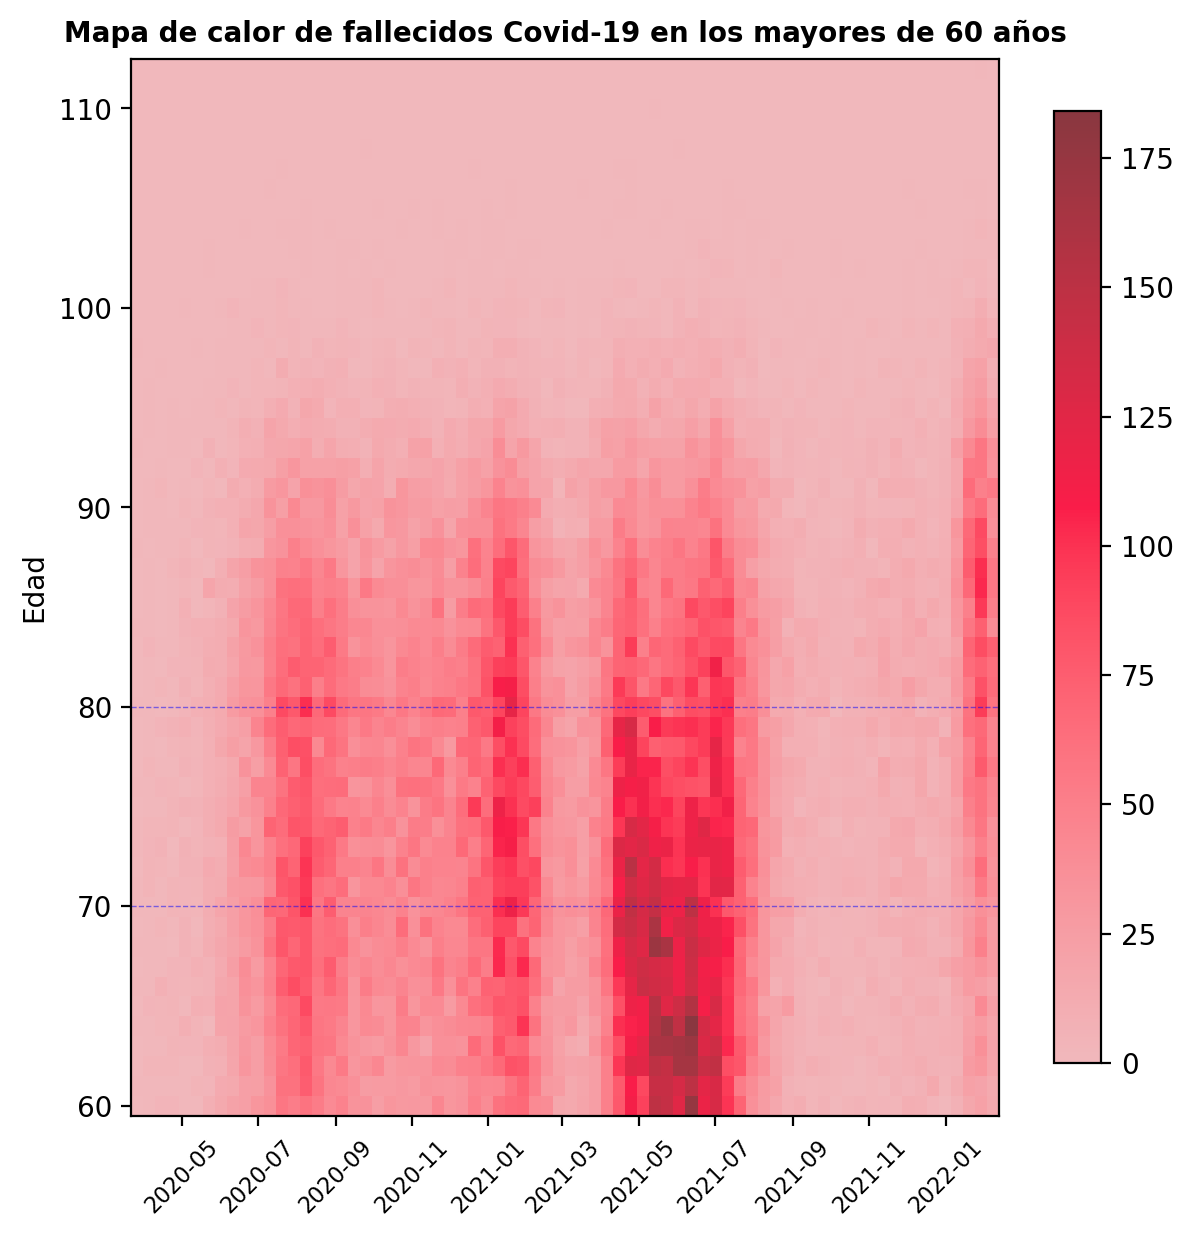

In [15]:
# Ploteamos mapa de calor año/mes vs edad fallecidos

plt.figure(figsize=(7,7), dpi=200)
sns.histplot(x="fecha_muerte", y="edad", data=mayores_59, discrete=(False, True),\
             color="#D10A38", thresh=None, cbar=True, cbar_kws=dict(shrink=.9))
plt.xticks(rotation=45, fontsize=8)
plt.xlabel("")
plt.ylabel("Edad")
plt.title("Mapa de calor de fallecidos Covid-19 en los mayores de 60 años",fontsize=10, fontweight="bold")
plt.axhline(y=70, color='b', linestyle='--', alpha=0.5, linewidth=.5)
plt.axhline(y=80, color='b', linestyle='--', alpha=0.5, linewidth=.5)
plt.show()

#### Interpretación:

Añadir

# Dataframe para menores de 60 años

In [23]:
# Llamamos los datos de la segunda consulta

results = client.get("gt2j-8ykr", query=query2)

In [24]:
# Realizamos mismos pasos 

menores_60 = pd.DataFrame.from_records(results)
menores_60.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36716 entries, 0 to 36715
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   fecha_reporte_web      36716 non-null  object
 1   departamento_nom       36716 non-null  object
 2   ciudad_municipio_nom   36716 non-null  object
 3   edad                   36716 non-null  object
 4   sexo                   36716 non-null  object
 5   ubicacion              36716 non-null  object
 6   estado                 36716 non-null  object
 7   recuperado             36716 non-null  object
 8   fecha_inicio_sintomas  36716 non-null  object
 9   fecha_muerte           36716 non-null  object
dtypes: object(10)
memory usage: 2.8+ MB


In [25]:
menores_60[["fecha_reporte_web","fecha_inicio_sintomas","fecha_muerte"]] = \
    menores_60[["fecha_reporte_web","fecha_inicio_sintomas","fecha_muerte"]].apply(pd.to_datetime)
menores_60["edad"] = menores_60["edad"].astype("int64")

print(menores_60.departamento_nom.unique())
print(menores_60.sexo.unique())
print(menores_60.ubicacion.unique())
print(menores_60.estado.unique())
print(menores_60.recuperado.unique())

['CUNDINAMARCA' 'BARRANQUILLA' 'NORTE SANTANDER' 'GUAJIRA' 'CESAR' 'META'
 'AMAZONAS' 'BOYACA' 'TOLIMA' 'BOGOTA' 'STA MARTA D.E.' 'CALDAS' 'NARIÑO'
 'VALLE' 'ANTIOQUIA' 'CORDOBA' 'ATLANTICO' 'CAUCA' 'SANTANDER' 'CHOCO'
 'CARTAGENA' 'MAGDALENA' 'CAQUETA' 'RISARALDA' 'SUCRE' 'HUILA' 'CASANARE'
 'QUINDIO' 'BOLIVAR' 'ARAUCA' 'PUTUMAYO' 'GUAINIA' 'SAN ANDRES' 'VICHADA'
 'GUAVIARE' 'VAUPES']
['F' 'M']
['Fallecido']
['Fallecido']
['Fallecido' 'fallecido']


In [26]:
# Organizamos datos

menores_60["recuperado"].replace({"fallecido":"Fallecido"}, inplace=True)
menores_60["departamento_nom"].replace({"BARRANQUILLA":"ATLANTICO","CARTAGENA":"BOLIVAR",\
                                        "STA MARTA D.E.":"MAGDALENA","Caldas":"CALDAS","Tolima":"TOLIMA"}, inplace=True)
menores_60["sexo"].replace({"f":"F","m":"M"},inplace=True)

In [27]:
# creamos columna año_mes para ignorar el día del mes en el que ocurrió el deceso

menores_60["año_mes"] = menores_60["fecha_muerte"].dt.strftime("%Y-%m")

In [28]:
# Por último, describimos dataframe, por si no hay valores numericos atípicos

menores_60.describe()

,edad
count,36716.000000
mean,48.126729
std,9.673309
min,1.000000
25%,43.000000
50%,51.000000
75%,56.000000
max,59.000000


Nada anormal por acá, ploteamos entonces con este dataframe

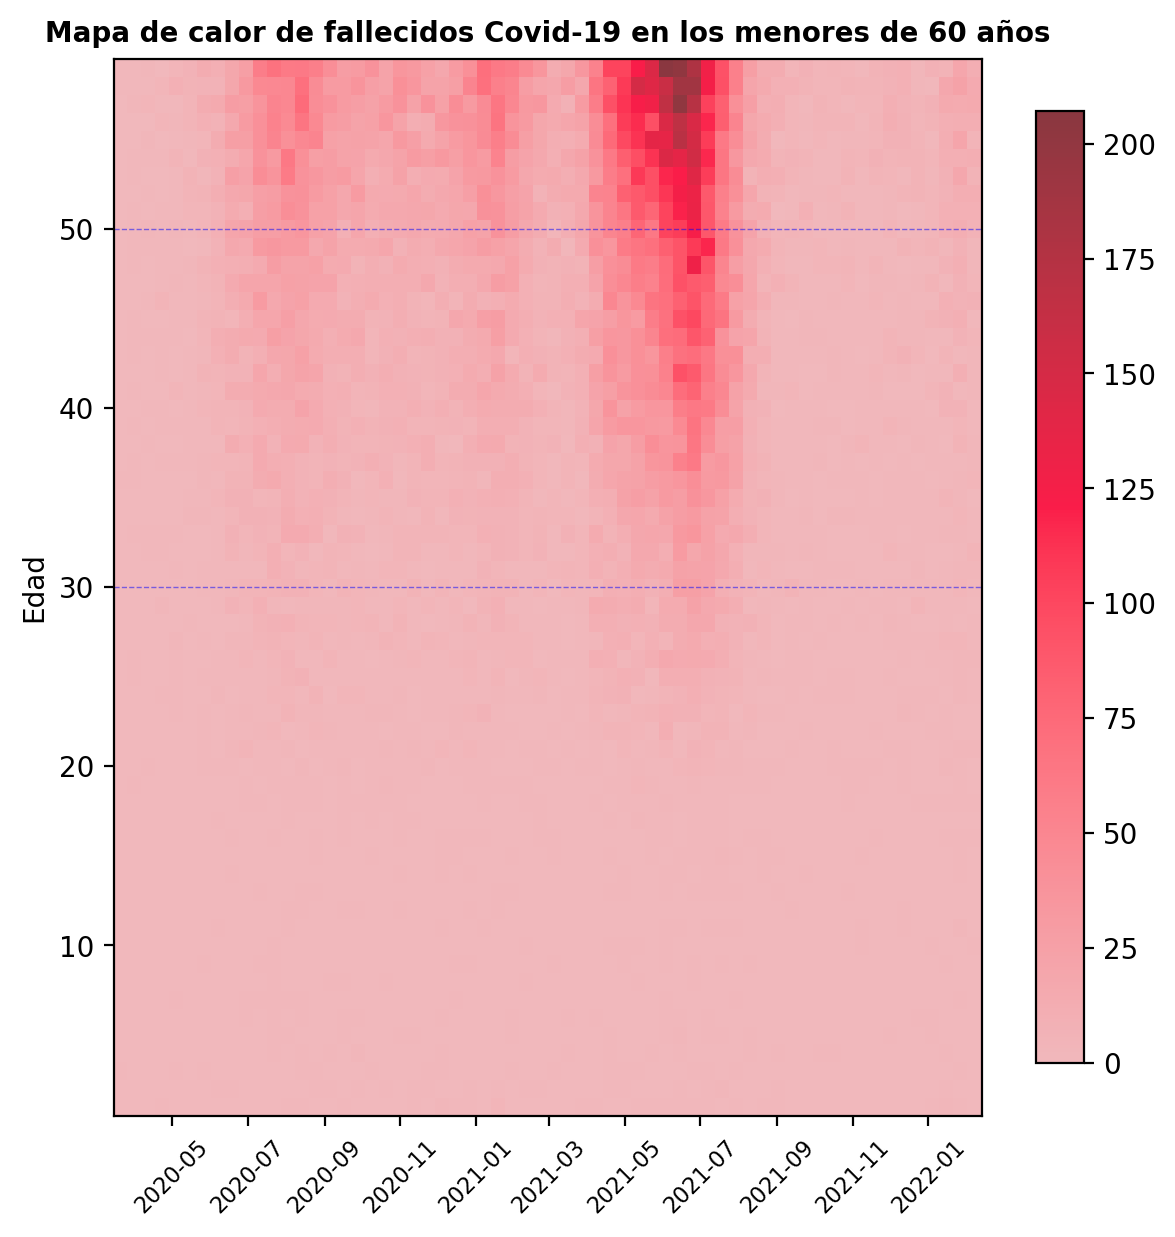

In [29]:
plt.figure(figsize=(7,7), dpi=200)
sns.histplot(x="fecha_muerte", y="edad", data=menores_60, discrete=(False, True), color="#D10A38", thresh=None, cbar=True, cbar_kws=dict(shrink=.9))
plt.xticks(rotation=45, fontsize=8)
plt.xlabel("")
plt.ylabel("Edad")
plt.title("Mapa de calor de fallecidos Covid-19 en los menores de 60 años",fontsize=10, fontweight="bold")
plt.axhline(y=50, color='b', linestyle='--', alpha=0.5, linewidth=.5)
plt.axhline(y=30, color='b', linestyle='--', alpha=0.5, linewidth=.5)
plt.show()

# Concatenación de dataframes para visualización general de los datos

In [30]:
# Creamos lista con el nombre de los dos df 
frames = [mayores_59, menores_60]

# Concatenamos 
all_ages = pd.concat(frames)

# Describimos
all_ages.describe()

,edad
count,137115.000000
mean,68.150895
std,15.418763
min,1.000000
25%,59.000000
50%,70.000000
75%,80.000000
max,112.000000


Al 13 de febrero de 2022, se habían reportado 137.115 muertes, el dato es correcto si verificamos la info dada por Minsalud. Las tablas están ahora en una sola.
A la visualización sería interesante graficarle el promedio de edad de los fallecidos, así podríamos ver en qué meses murieron más jovenes y más adultos mayores.

In [31]:
# Creamos df agrupado por fecha de muerte y edad calculado por promedio
all_muertes = all_ages.groupby("fecha_muerte")["edad"].mean().reset_index()

# Como el promedio puede ser muy cambiante, vamos a utilizar un promedio móvil de 7 días para suavizar los datos
all_muertes["media_movil"] = all_muertes["edad"].rolling(window=7).mean()

# Evitamos transformación de la curva al princpio de la pandemia, pues puede alterar el análsis.
# Usamos .mask para reemplazar valores según la condición fecha_muerte ANTES DE (<) el 1° de mayo de 2020
# Reemplzamos con np.nan 
all_muertes["media_movil"] = all_muertes["media_movil"].mask\
(all_muertes["fecha_muerte"] < "2020-05-01", np.nan).astype(float) 

# Comprobamos .mask
all_muertes.head(10)

,fecha_muerte,edad,media_movil
0,2020-03-15,36.000000,NaN
1,2020-03-16,58.000000,NaN
2,2020-03-22,70.000000,NaN
3,2020-03-23,88.000000,NaN
4,2020-03-24,3.000000,NaN
5,2020-03-25,61.000000,NaN
6,2020-03-26,71.500000,NaN
7,2020-03-27,52.333333,NaN
8,2020-03-28,65.200000,NaN
9,2020-03-29,33.000000,NaN


Como recomendación, cambiaría el nombre de la columna "edad" a "promedio_edad" para evitar confusiones.

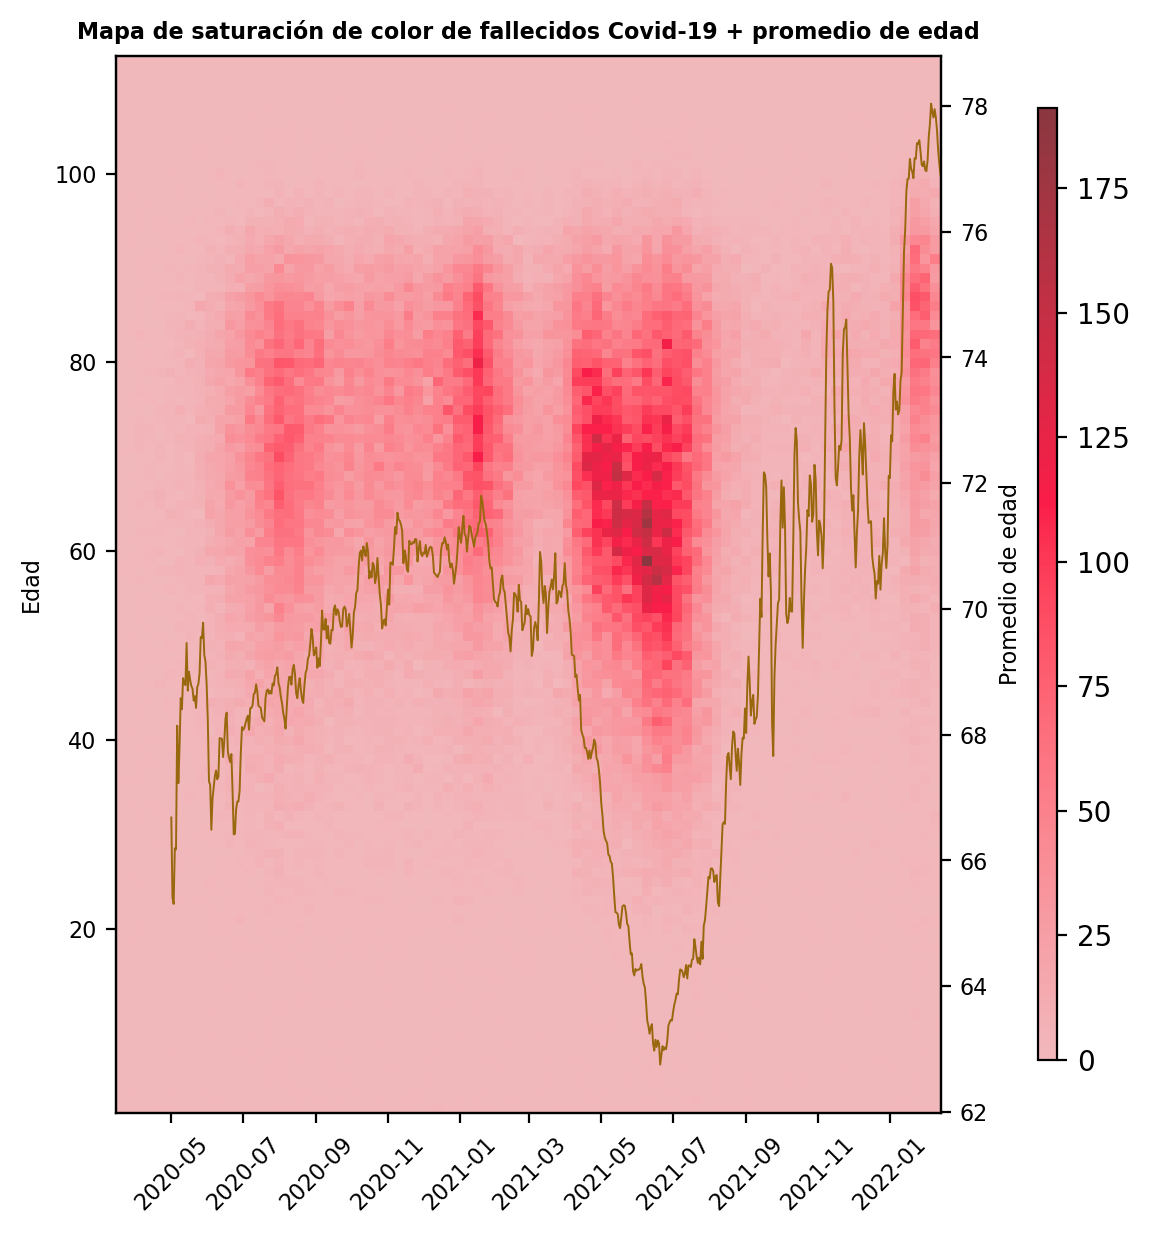

In [32]:
# Plotemos data unida

plt.figure(figsize=(7,7), dpi=200)
ax = sns.histplot(x="fecha_muerte", y="edad", data=all_ages, discrete=(False, True), color="#D10A38", thresh=None, cbar=True,\
                  cbar_kws=dict(shrink=.9, pad=0.09, aspect=50))
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("")
plt.ylabel("Edad", fontsize=8)
plt.title("Mapa de saturación de color de fallecidos Covid-19 + promedio de edad",fontsize=8, fontweight="bold")

# Insertamos curva de promedio de edad en el histplot mapeado
ax2 = ax.twinx()
sns.lineplot(x="fecha_muerte",y="media_movil", data=all_muertes, ax=ax2, color="#99680E", linewidth=0.7)
plt.ylabel("Promedio de edad", fontsize=8)
plt.yticks(fontsize=8)
plt.show()


# ¿Qué nos muestra el gráfico?

* En la cuarta oleada, hubo mayor cantidad de muertes en los adultos mayores (eje Y derecho) de 75 años, mientras que en las oleadas anteriores, el promedio de edad estuvo entre los 62 y 70. 

* La caída que hubo en el tercer pico se debe a que hubo mayor protección en los mayores de 70, pues fue el primer grupo poblacional en recibir las vacunas contra el Covid-19, no debemos olvidar, que la vacunación inició a un ritmo muy lento.

* Claramente se nota cómo el tercer pico fue el que más muertes trajo entre los 60 y 70 años, mientras que en el actual, hay mayor proporción en los mayores de 80.

* También se nota lo prolongado que fue el pico de Mu (tercero); éste último, aunque no ha terminado del todo (al 13 de febrero de 2022), va a ser el más corto.

Algunos se preguntarán, ¿entonces por qué murieron tantos adultos mayores como en el tercer pico? 

Varios factores:
- Baja cobertura en las dosis de refuerzo
- La Efectividad de las vacunas baja drásticamente a mayor edad y a medida que pasa el tiempo
- Comorbilidades presentes en estos grupos etarios
- Población que siempre va a estar en mayor riesgo

No es lo mismo la efectividad de dos dosis a los 6 meses en una persona joven y sana que en un adulto mayor, si hay algo que rescatar, es que el pico fue de menor duración, o sea, menos muertes tomando el acumulado.
Pasamos de +23.000 en el tercer pico a +5.000 en el actual.

#### Aclaración con respecto al manejo de la base de datos

Debido a que conozco muy bien la base de datos, pude saltarme muchas cosas que se harían normalmente en un análisis exploratorio, por lo que acá traté de ir de la manera más resumida para llegar a las visualizaciones sin que se tornara engorroso el proceso.

Realizado por Julián Gómez
Base de datos del Instituto Nacional de Salud, en conjunto con el Ministerio de Salud (MINSALUD Colombia).